In [1]:
import numpy as np

In [2]:
from sklearn.datasets import fetch_mldata

In [3]:
mnist = fetch_mldata('MNIST original')

/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/davescott/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [42]:
X, y = mnist["data"[:70000]], mnist["target"[:70000]]

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.142857)

In [45]:
shuffle_index=np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Random Forest Classifier and Training before applying PCA

In [46]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=50, max_leaf_nodes=32, n_jobs=-1, random_state=30)
rnd_clf2 = RandomForestClassifier(n_estimators=50, max_leaf_nodes=32, n_jobs=-1, random_state=30)

In [47]:
import time

In [48]:
start = time.time()
rnd_clf.fit(X_train, y_train)
end = time.time()
print(end - start)

2.4809019565582275


### our model takes 2.4 seconds to train without dimensionality reduction.

In [49]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [50]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

In [51]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [52]:
start = time.time()
rnd_clf2.fit(X_reduced, y_train)
end = time.time()
print(end - start)

4.04552698135376


### We can see for our reduced dimension dataset the training is actually substantially longer. This usually is due to the dataset itself. Some datasets are better than others for dimensionality reduction.

In [54]:
from sklearn.metrics import accuracy_score
X_test_reduced = pca.transform(X_test)
y_pred = rnd_clf.predict(X_test)
y_pred2 = rnd_clf2.predict(X_test_reduced)

print(accuracy_score(y_pred, y_test))
print(accuracy_score(y_pred2, y_test))

0.8552
0.8265


## A slight decrease in performance, as well as slowing down training. This is a single case, but it's important to remember that in other settings we may be able to have much more time saved for training with a minimal decrease in model performance.

# Utilizing t-SNE to decrease MNIST to two dimensions and plot the resulting with Matplotlib

In [57]:
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Let's look at the first 25000 data samples for t-SNE, also utilize pandas df for plotting and analysis.
##### Note: I adjusted this after for 5000 because of troubleshooting.

In [117]:
N = 5000
import pandas as pd
rndperm = np.random.permutation(df.shape[0])
feat_cols = ['pixel'+str(i) for i in range(X_train.shape[1])]
df = pd.DataFrame(X_train, columns=feat_cols)
df['y_train'] = y_train
df['label'] = df['y_train'].apply(lambda i: str(i))

df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values

In [118]:
start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
end = time.time()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.193s...
[t-SNE] Computed neighbors for 5000 samples in 28.852s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 477.306489
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.364372
[t-SNE] KL divergence after 300 iterations: 2.137683


In [75]:
print(end-start)

1134.6572470664978


## Fairly long process at almost twenty minutes.

In [121]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
tsne_results
import seaborn as sns
df_subset['label'] = df_subset['label']

/Users/davescott/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1152x720 with 0 Axes>

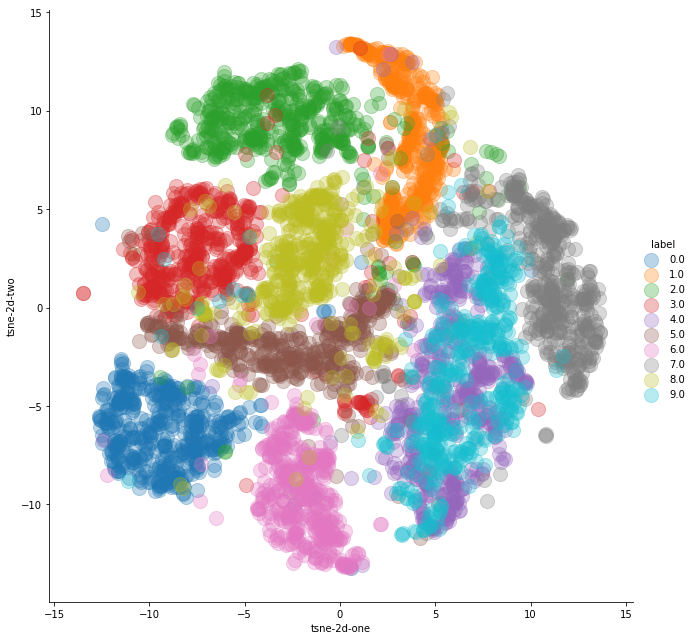

In [123]:
plt.figure(figsize=(16, 10))
sns.lmplot(
    x='tsne-2d-one', 
    y='tsne-2d-two',
    data=df_subset,
    fit_reg=False,
    legend=True,
    size=9,
    hue = 'label',
    scatter_kws={"s":200, "alpha":0.3}
)

# We have a visual representatition of the clustering for the first 5000 results. It appears failry 'decent' ;)

## Let's do a quick comparison with PCA to see how PCA performs.

In [124]:
start = time.time()
pca = PCA(n_components=2, random_state=30)
X_reduced = pca.fit_transform(X_train)
end = time.time()
print(end - start)

1.2414510250091553


In [133]:
def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl

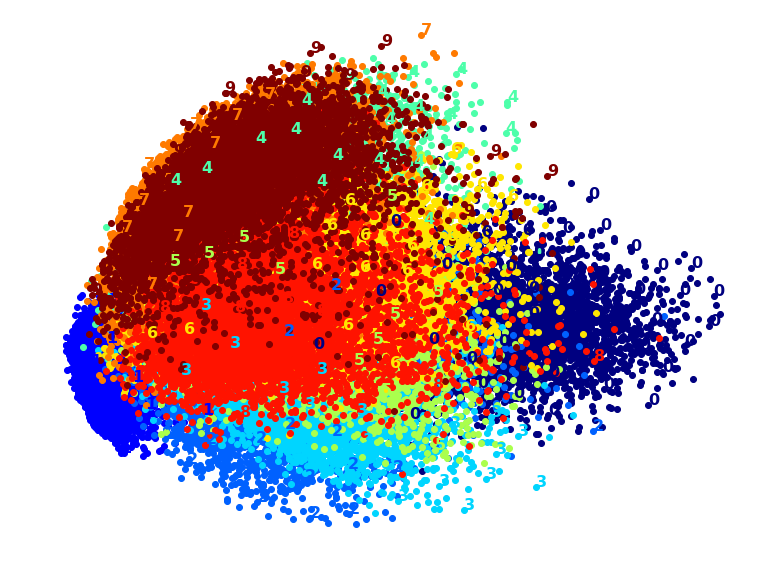

In [134]:
plot_digits(X_reduced, y_train)

## The criterion of visualization helps us identify that there are boundaries that need to be improved. For example, 4 and 9.